### Example with DataLinks and LinkProbability class
Testing a way to measure scores from co-occurences in the data.

In [1]:
# import from NPlinker
from nplinker_constants import nplinker_setup
from metabolomics import load_spectra
from metabolomics import load_metadata
from metabolomics import load_edges
from metabolomics import make_families
from genomics import loadBGC_from_cluster_files
from genomics import make_mibig_bgc_dict

from data_linking import DataLinks
from data_linking import LinkProbability

# import general packages
import os
import glob

In [2]:
# data locations
DATASET = "C:\\Users\\FlorianHuber\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA"
PATH_MS2LDA = DATASET + "\\lda\\code\\"
PATH_MGF_DATA = DATASET + "\\Data\\Crusemann_dataset\\Crusemann_only_Clutered_Data\\"
MIBIG_JSON_DIR = DATASET + "\\Data\\mibig\\mibig_json_1.4"

NODES_FILE = PATH_MGF_DATA + "clusterinfosummarygroup_attributes_withIDs\\0d51c5b6c73b489185a5503d319977ab..out"

MGF_FILE = PATH_MGF_DATA + "METABOLOMICS-SNETS-c36f90ba-download_clustered_spectra-main.mgf"
EDGES_FILE = PATH_MGF_DATA + 'networkedges_selfloop\\9a93d720f69143bb9f971db39b5d2ba2.pairsinfo'

ROOT_PATH = DATASET + "\\Data\mibig_select\\"
FOLDERS = ['NRPS','Others','PKSI','PKS-NRP_Hybrids','PKSother','RiPPs','Saccharides','Terpene']
ANTISMASH_DIR = DATASET +"\\Data\\Crusemann_dataset\\bgc_crusemann\\"

In [3]:
# load, initialize data
nplinker_setup(LDA_PATH=PATH_MS2LDA)

spectra = load_spectra(MGF_FILE)
load_edges(spectra, EDGES_FILE)
#families = make_families(spectra)
metadata = load_metadata(spectra, NODES_FILE)

input_files = []
ann_files = []
mibig_bgc_dict = make_mibig_bgc_dict(MIBIG_JSON_DIR)

for folder in FOLDERS:
    fam_file = os.path.join(ROOT_PATH, folder)
    cluster_file = glob.glob(fam_file + os.sep + folder + "_clustering*")
    annotation_files = glob.glob(fam_file + os.sep + "Network_*")
    input_files.append(cluster_file[0])
    ann_files.append(annotation_files[0])
gcf_list, bgc_list, strain_list = loadBGC_from_cluster_files(input_files, ann_files, antismash_dir=ANTISMASH_DIR, antismash_format = 'flat', mibig_bgc_dict=mibig_bgc_dict)

Loaded 5930 molecules
Found 1816 MiBIG json files


Now the data from the gene cluster families and spectra is loaded and initilized. 

The classes **DataLinks** and **LinkProbability** were written to test a possible alternative way to get correlation scores. The scoring is based on creating numpy co-occurence matrices which in principle should allow for very fast calculations.

In [4]:
# extract relevant linking mappings calculate co-occurences
data_links = DataLinks()
data_links.load_data(spectra, gcf_list, strain_list)
data_links.find_correlations(include_singletons=False)

Create mappings between spectra, gcfs, and strains.
Create co-occurence matrices: spectra<->strains + and gcfs<->strains.
Create correlation matrices: spectra<->gcfs.
Calculating correlation matrices of type:  spec-gcf
  Done  1574  of  1574  GCFs.
  Done  5900  of  5930  spectra/families. 5930  of  5930  spectra/families.
Create correlation matrices: mol-families<->gcfs.
Calculating correlation matrices of type:  fam-gcf
  Done  1574  of  1574  GCFs.
  Done  458  of  458  spectra/families.


In [5]:
# Calculate link probabilities, such as:
# P(gcf_x | spec_y) = probability to find gcf_x in a strain, given spec_y is present
# P(gcf_x | not spec_y) = probability to find gcf_x in a strain, given spec_y is NOT present 
link_probs = LinkProbability()
link_probs.correlation_probabilities(data_links, type='spec-gcf')
link_probs.correlation_probabilities(data_links, type='fam-gcf')

Calculating probability matrices of type:  spec-gcf
Calculating probability matrices of type:  fam-gcf


### Select potential link candidates
#### 1. Search for links between GCFs and spectra
Done based on on the probaility (or co-occurence rate) P(gcf_x | spec_y).
This is then weighted by the number of strains this co-occurence was found in.

In [6]:
link_probs.select_link_candidates(data_links, P_cutoff = 0.9, score_cutoff=0.7, type='spec-gcf')

109859  candidates selected with  P(gcf|spec)  >=  0.9  .
44983  candidates selected with  P(gcf|spec)  >=  0.9  and a link score >=  0.7 .


In [7]:
# Get table of potential gcf<-> spectrum link candidates
link_candidates = link_probs.link_candidates_gcf_spec

link_candidates.head()

,spectrum_id,GCF id,P(gcf|spec),P(spec|gcf),P(gcf|not spec),P(spec|not gcf),co-occur in # strains,link score,BGC class
0,36.0,500.0,1.000000,0.120000,0.163121,0.000000,3.0,0.776870,Others
1,36.0,992.0,1.000000,0.375000,0.042553,0.000000,3.0,0.776870,Others
2,46.0,323.0,0.909091,2.500000,0.022556,0.007143,10.0,0.896516,Others
3,46.0,390.0,0.909091,1.000000,0.067669,0.007463,10.0,0.896227,Others
4,46.0,401.0,0.909091,3.333333,0.015038,0.007092,10.0,0.896561,Others


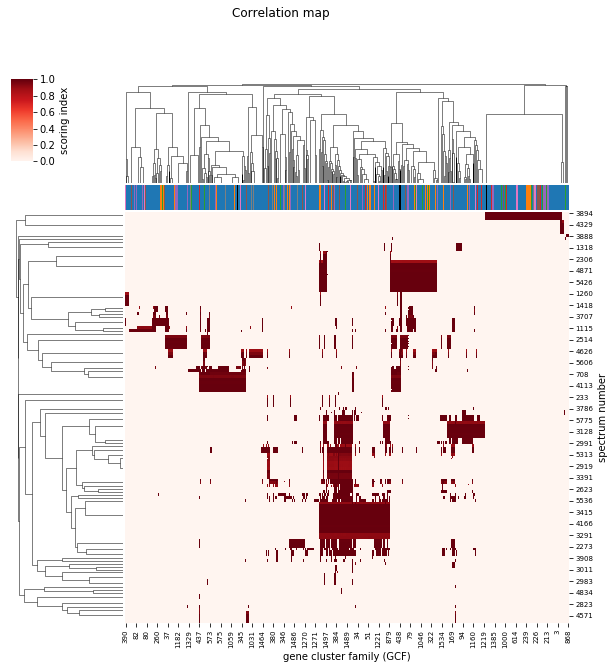

In [8]:
# do some test plotting to inspect the kind of results we get from there...
M_links = link_probs.plot_candidates(P_cutoff=0.95, score_cutoff=0.99, type='spec-gcf')

#### 2. Search for links between GCFs and molecular families
Done based on on the probaility (or co-occurence rate) P(gcf_x | fam_y).
Again, this is then weighted by the number of strains this co-occurence was found in.

In [9]:
# Select candidates based on the probaility (or co-occurence rate) P(gcf_x | fam_y) 
link_probs.select_link_candidates(data_links, P_cutoff = 0.8, score_cutoff=0, type='fam-gcf')

3802  candidates selected with  P(gcf|fam)  >=  0.8  .
3802  candidates selected with  P(gcf|fam)  >=  0.8  and a link score >=  0 .


In [10]:
# Get table of potential gcf<-> mol.family link candidates
link_candidates = link_probs.link_candidates_gcf_fam

link_candidates.head()

,family_id,GCF id,P(gcf|fam),P(fam|gcf),P(gcf|not fam),P(fam|not gcf),co-occur in # strains,link score,BGC class
0,9.0,1352.0,0.833333,0.113636,0.282609,0.010000,5.0,0.757280,RiPPs
1,9.0,1471.0,0.833333,0.166667,0.181159,0.008772,5.0,0.758219,Saccharides
2,16.0,323.0,1.000000,0.250000,0.020979,0.000000,1.0,0.393469,Others
3,16.0,390.0,1.000000,0.100000,0.062937,0.000000,1.0,0.393469,Others
4,16.0,401.0,1.000000,0.333333,0.013986,0.000000,1.0,0.393469,Others


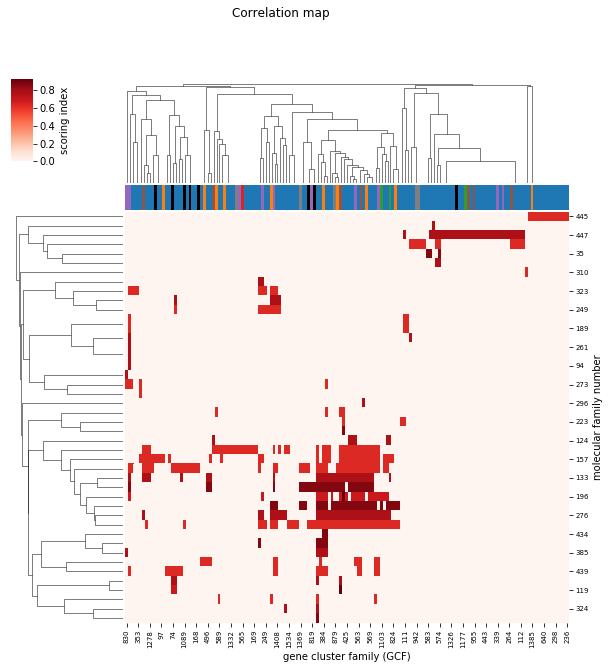

In [11]:
# do some test plotting to inspect the kind of results we get from there...
M_links = link_probs.plot_candidates(P_cutoff=0.9, score_cutoff=0.5, type='fam-gcf')